In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandahouse
%matplotlib inline

# A/A №1

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

### Описание данных

* experimentVariant – вариант эксперимента
* version – версия приложения
* purchase – факт покупки

### Задача

* Построить гистограмму распределения получившихся 10000 p-values.
* Посчитать, какой процент p values оказался меньше либо равен 0.05
* Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [9]:
data = pd.read_csv('hw_aa.csv', sep = ';').drop('Unnamed: 0', axis = 1)
data.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [10]:
test_purchase = data.query('experimentVariant == 1').purchase
control_purchase = data.query('experimentVariant == 0').purchase

In [14]:
n_sample = 500
n_simulations = 10000
p_list = []
for i in range(n_simulations): # Проводим A/A тест 10_000 раз 
    test_group = test_purchase.sample(n_sample, replace = False)
    control_group = control_purchase.sample(n_sample, replace = False)
    test = stats.ttest_ind(test_group, control_group, equal_var = False) # в каждом тесте считаем p-value, p_value < 0.05 значит нашли различия
    p_list.append(test[1])

In [15]:
print(f'FPR = {(pd.Series(p_list) < 0.05).sum() / n_simulations}') # подсчет FPR, FPR получился > 0.05, система сплитования не работает

FPR = 0.6809


<Axes: ylabel='Count'>

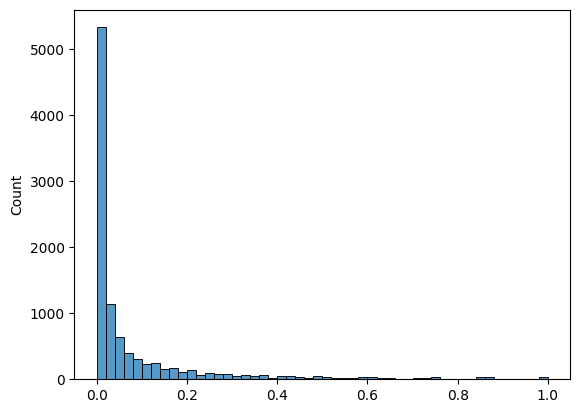

In [16]:
sns.histplot(p_list, bins = 50)

**Вывод**: FPR превышает 0.05, распределение FPR по p-value неравномерно. В системе сплитования ошибка.

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

1. Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
2. Посчитайте pvalue для каждой версии МП
3. Найдите версии, где pvalue < 0.05
4. Исключите версию с pvalue < 0.05 из основного датафрейма
5. Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
6. Вы нашли поломку

1. Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки

In [18]:
purchases = data.query('purchase == 1').groupby(['experimentVariant','version'], as_index = False).purchase.count()
purchases.head()

,experimentVariant,version,purchase
0,0,v2.8.0,41
1,0,v2.9.0,890
2,0,v3.7.4.0,252
3,0,v3.8.0.0,328
4,1,v2.8.0,1895


In [19]:
fpr_data = data.groupby(['experimentVariant','version'], as_index = False).purchase.count()
fpr_data.head()

,experimentVariant,version,purchase
0,0,v2.8.0,41283
1,0,v2.9.0,11921
2,0,v3.7.4.0,4204
3,0,v3.8.0.0,5694
4,1,v2.8.0,41552


In [20]:
fpr_data['сtr'] = purchases.purchase / fpr_data.purchase * 100
fpr_data

,experimentVariant,version,purchase,сtr
0,0,v2.8.0,41283,0.099314
1,0,v2.9.0,11921,7.465817
2,0,v3.7.4.0,4204,5.994291
3,0,v3.8.0.0,5694,5.760450
4,1,v2.8.0,41552,4.560551
5,1,v2.9.0,12033,7.130391
6,1,v3.7.4.0,4221,6.301824
7,1,v3.8.0.0,6110,6.284779


2. Посчитайте pvalue для каждой версии МП

In [22]:
data.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

У нас есть 4 версии мобильного приложения, для каждой версии посчитаем p-value с помощью t-test (сравниваем колонки purchase у контрольной и экспериментальной группы для каждого мобильного приложения)

In [23]:
control_280 = data.query('(version == "v2.8.0") & (experimentVariant == 0)').purchase
test_280 = data.query('(version == "v2.8.0") & (experimentVariant == 1)').purchase
stats.ttest_ind(control_280, test_280)

TtestResult(statistic=-42.963540840360324, pvalue=0.0, df=82833.0)

In [24]:
control_290 = data.query('(version == "v2.9.0") & (experimentVariant == 0)').purchase
test_290 = data.query('(version == "v2.9.0") & (experimentVariant == 1)').purchase
stats.ttest_ind(control_290, test_290)

TtestResult(statistic=0.9979597634962479, pvalue=0.3183089516720744, df=23952.0)

In [25]:
control_374 = data.query('(version == "v3.7.4.0") & (experimentVariant == 0)').purchase
test_374 = data.query('(version == "v3.7.4.0") & (experimentVariant == 1)').purchase
stats.ttest_ind(control_374, test_374)

TtestResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735, df=8423.0)

In [26]:
control_380 = data.query('(version == "v3.8.0.0") & (experimentVariant == 0)').purchase
test_380 = data.query('(version == "v3.8.0.0") & (experimentVariant == 1)').purchase
stats.ttest_ind(control_374, test_374)

TtestResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735, df=8423.0)

Мы получили статистически значимые различия в версии 2.8.0, возможно в ней сломана система сплитования

4. Исключите версию с pvalue < 0.05 из основного датафрейма

In [27]:
new_df = data[data.version != 'v2.8.0']
new_df.head()

,uid,experimentVariant,version,purchase
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
6,8f14e45fceea167a5a36dedd4bea2543,0,v2.9.0,0
10,6512bd43d9caa6e02c990b0a82652dca,1,v2.9.0,0
13,aab3238922bcc25a6f606eb525ffdc56,1,v2.9.0,0


In [28]:
test_group = new_df.query('experimentVariant == 0').purchase
control_group = new_df.query('experimentVariant == 1').purchase

In [29]:
n_sample = 500
n_test = 10_000
p_list = []
for i in range (n_test):
    test_sample = test_group.sample(n_sample, replace = False)
    control_sample = control_group.sample(n_sample, replace = False)
    result = stats.ttest_ind(test_sample, control_sample, equal_var = False)
    p_list.append(result[1])

Подсчитаем FPR заново, теперь он должен быть < 0.05

In [30]:
fpr = sum(list(map(lambda x: x < 0.05, p_list))) / n_test
fpr

0.0462

<Axes: ylabel='Count'>

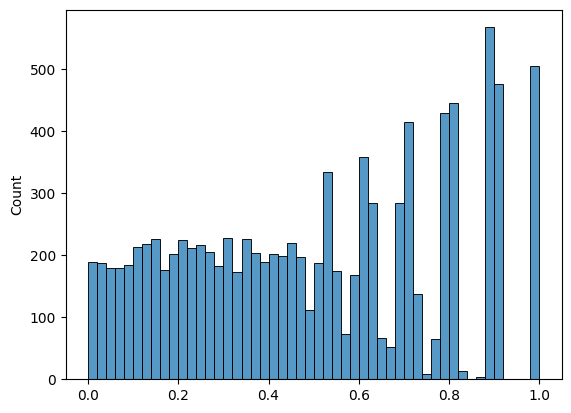

In [31]:
sns.histplot(p_list, bins = 50)

# A/A №2

У нас есть данные АА-теста с '2022-01-07' по '2022-01-13'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

### Задача:

1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [34]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': '*****************'
}

query = '''
SELECT user_id,
       exp_group,
       countIf(user_id, action = 'like' ) as like,
       countIf(user_id, action = 'view' ) as view,
       like/view as ctr
FROM simulator_20220120.feed_actions
WHERE (toDate(time) >= '2022-01-07' AND toDate(time) <= '2022-01-13' 
AND exp_group in [2,3])
GROUP BY user_id, exp_group
'''

df = pandahouse.read_clickhouse(query, connection=connection)

In [35]:
df

,user_id,exp_group,like,view,ctr
0,115383,3,11,36,0.305556
1,123580,3,15,92,0.163043
2,131473,2,26,148,0.175676
3,23985,2,12,66,0.181818
4,24523,2,17,120,0.141667
...,...,...,...,...,...
17044,122008,3,4,31,0.129032
17045,25383,2,16,57,0.280702
17046,122190,3,25,74,0.337838
17047,108927,2,8,33,0.242424


In [36]:
df.groupby('exp_group').ctr.mean()

exp_group
2    0.218246
3    0.219161
Name: ctr, dtype: float64

In [37]:
group_2 = df.query('exp_group == 2').ctr
group_3 = df.query('exp_group == 3').ctr

### Тест на нормальность распределений

In [38]:
stats.normaltest(group_2)

NormaltestResult(statistic=1334.8989408193358, pvalue=1.3501376613275468e-290)

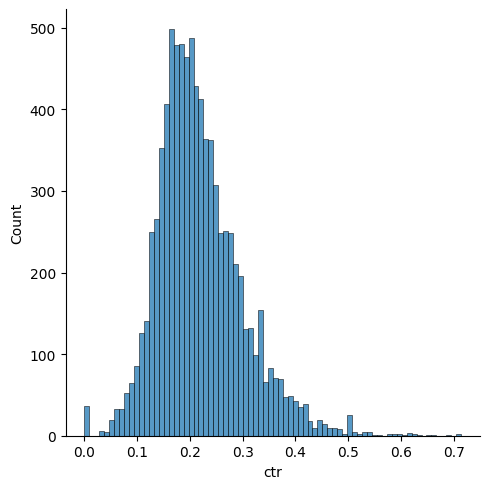

In [39]:
sns.displot(group_2)

In [40]:
stats.normaltest(group_3)

NormaltestResult(statistic=1223.6563719492806, pvalue=1.9337260968139493e-266)

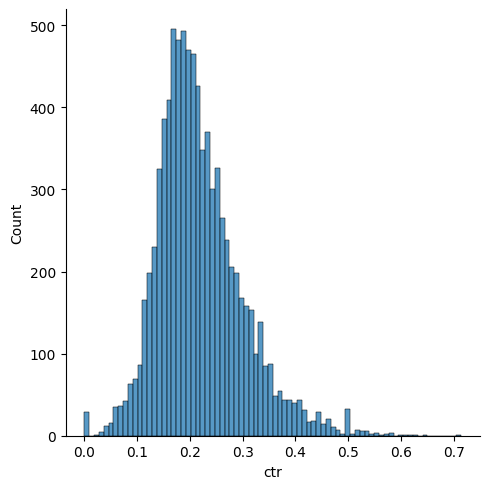

In [41]:
sns.displot(group_3)

### Тест на однородность дисперсий (дисперсии гомогенны)

In [42]:
stats.levene(group_2, group_3) 

LeveneResult(statistic=0.07008986609971159, pvalue=0.7912091809509416)

In [46]:
n_sample = 500
n_test = 10_000
p_list = []
for i in range (n_test):
    group_2_sample = group_2.sample(n_sample, replace = False)
    group_3_sample = group_3.sample(n_sample, replace = False)
    test = stats.ttest_ind(group_2_sample, group_3_sample)
    p_list.append(test[1])

In [47]:
fpr = sum(list(map(lambda x: x < 0.05, p_list))) / n_test
if fpr < 0.05:
    print(f"FPR = {fpr}, FPR < 0.05 Система сплитования работает корректно")
else:
    print(f"FPR = {fpr}, FPR > 0.05 Система сплитования работает некорректно")

FPR = 0.0495, FPR < 0.05 Система сплитования работает корректно


<Axes: ylabel='Count'>

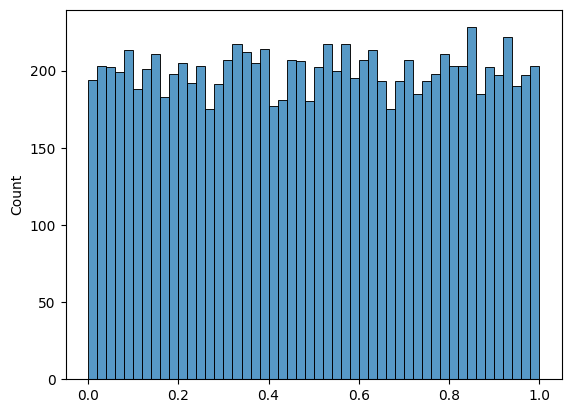

In [48]:
sns.histplot(p_list,bins = 50)